In [77]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from neo4j import GraphDatabase
from neo4_connection import USER, PWD, URL 

from sklearn import model_selection, metrics, preprocessing
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [79]:
driver = GraphDatabase.driver(uri=URL, auth=(USER, PWD))

def fetch_data(query):
  with driver.session() as session:
    result = session.run(query)
    return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [80]:
query = """
MATCH (u:User) -[r:RATED]-> (m:Movie)
RETURN u.userId AS userId, 
    m.movieId AS movieId, 
    r.rating AS rating
ORDER BY userId, movieId
"""

df = fetch_data(query)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [81]:
assert len(df) == 100004, 'Query result is wrong!'

In [82]:
df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [83]:
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()
n_nodes = n_users + n_movies

print(f'# Users: {n_users}\n# Movies: {n_movies}\n# Nodes: {n_nodes}')

# Users: 671
# Movies: 9066
# Nodes: 9737


In [84]:
df['rating'].value_counts()

4.0    28750
3.0    20064
5.0    15095
3.5    10538
4.5     7723
2.0     7271
2.5     4449
1.0     3326
1.5     1687
0.5     1101
Name: rating, dtype: int64

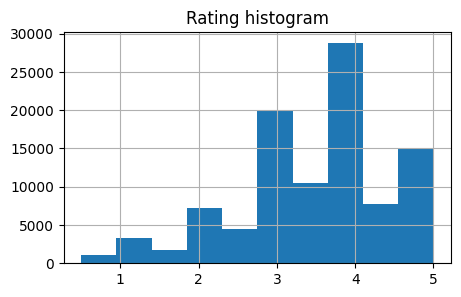

In [85]:
df['rating'].hist(bins=10, figsize=(5,3))
plt.title('Rating histogram')
plt.show()

In [86]:
class MovieDataset:
    def __init__(self, users:np.array, movies:np.array, ratings:np.array) -> None:
        self.users = users
        self.movies = movies
        self.ratings = ratings

    def __len__(self) -> int:
        return len(self.users)

    def __getitem__(self, item:int) -> dict:

        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]

        return {
            "users": torch.tensor(users), #dtype=torch.long
            "movies": torch.tensor(movies), #dtype=torch.long
            "ratings": torch.tensor(ratings) #dtype=torch.long
        }

In [87]:
# Reset user ID's and movie ID's to starting index 0.
# This avoids index errors
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
df['userId'] = lbl_user.fit_transform(df['userId'].values)
df['movieId'] = lbl_movie.fit_transform(df['movieId'].values)

In [88]:
df_train, df_val = model_selection.train_test_split(
    df, test_size=0.2, random_state=33, stratify=df['rating'].values)

df_test, df_val = model_selection.train_test_split(
    df_val, test_size=0.5, random_state=33, stratify=df_val['rating'].values)

In [89]:
train_dataset = MovieDataset(
    users=df_train['userId'].values,
    movies=df_train['movieId'].values,
    ratings=df_train['rating'].values)

val_dataset = MovieDataset(
    users=df_val['userId'].values,
    movies=df_val['movieId'].values,
    ratings=df_val['rating'].values)

test_dataset = MovieDataset(
    users=df_val['userId'].values,
    movies=df_val['movieId'].values,
    ratings=df_val['rating'].values)

print(f'Train: {len(train_dataset)}\nVal: {len(val_dataset)}\nTest: {len(test_dataset)}')

Train: 80003
Val: 10001
Test: 10001


In [90]:
train_dataset.__getitem__(0)

{'users': tensor(29),
 'movies': tensor(2965),
 'ratings': tensor(4., dtype=torch.float64)}

In [91]:
BATCH_SIZE = 4
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True)

In [92]:
data_iter = iter(train_loader)
dataloader_data = data_iter.next()
print(dataloader_data)

{'users': tensor([345, 515, 311,  22]), 'movies': tensor([3017,  381, 1480, 5615]), 'ratings': tensor([5.0000, 3.0000, 1.0000, 3.5000], dtype=torch.float64)}


In [93]:
class RecSysModel(nn.Module):
    def __init__(self, n_users:int, n_movies:int, embedding_dim:int) -> None:
        super().__init__()
        self.user_embed = nn.Embedding(num_embeddings=n_users, embedding_dim=embedding_dim)
        self.movie_embed = nn.Embedding(num_embeddings=n_movies, embedding_dim=embedding_dim)
        self.out = nn.Linear(in_features=embedding_dim*2, out_features=1)

    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        embeds_concat = torch.cat([user_embeds, movie_embeds], dim=1)
        output = self.out(embeds_concat)
        
        return user_embeds, movie_embeds, output

In [94]:
model = RecSysModel(
    n_users=n_users,
    n_movies=n_movies,
    embedding_dim=8
).to(device)


In [95]:
optimizer = torch.optim.Adam(model.parameters())

loss_func = nn.MSELoss()

In [96]:
# Manual walktrough trainings iteration
for i, train_data in enumerate(train_loader):
    print('One trainingsbatach:\n', train_data)
    model.train(True)

    # Show embeddings
    print(f'\nEmbeddings for USER ({train_data["users"]}):\n{model.user_embed(train_data["users"])}')
    print(f'\nEmbeddings for MOVIE ({train_data["movies"]}):\n{model.movie_embed(train_data["movies"])}')

    # Model output -> Model input a tensor of users and a tensor of movies
    _, _, output = model(train_data['users'], train_data['movies'])
    print('\nModel output:', output.view(-1))

    # Calculate loss
    rating = train_data['ratings'].view(BATCH_SIZE, -1).to(torch.float32)
    loss = loss_func(output, rating)
    print(f'Ground truth: {rating.view(-1)}')
    print('\nLoss:', loss)

    rating = train_data['ratings'].view(BATCH_SIZE, -1).to(torch.float32)
    break

One trainingsbatach:
 {'users': tensor([231, 239, 639,  56]), 'movies': tensor([1676,  344,  441,  100]), 'ratings': tensor([4.0000, 1.5000, 4.0000, 5.0000], dtype=torch.float64)}

Embeddings for USER (tensor([231, 239, 639,  56])):
tensor([[-5.3701e-01,  4.4126e-01, -4.6971e-01, -9.3519e-03, -3.8798e-01,
          5.2451e-01, -5.2661e-01, -5.2747e-01],
        [ 5.7045e-01,  2.1200e+00,  8.1065e-01, -9.5502e-01,  1.2695e+00,
         -1.7057e+00, -1.6035e+00, -1.3132e+00],
        [-2.1476e-01,  2.2607e+00, -3.7653e-01, -8.1139e-01, -8.6654e-01,
          6.2533e-01, -3.6182e-02, -8.5934e-01],
        [-6.7498e-01,  9.8108e-01,  2.3006e+00, -8.0079e-01, -5.0932e-04,
         -1.5087e+00,  9.1015e-01, -4.9817e-01]], grad_fn=<EmbeddingBackward0>)

Embeddings for MOVIE (tensor([1676,  344,  441,  100])):
tensor([[ 0.3380, -0.0330,  2.1058, -0.4328, -1.2705,  1.1615,  1.1682,  1.1911],
        [-2.0847, -1.1258,  2.4786, -0.7534,  0.1310,  0.1571,  0.2493,  0.4541],
        [-0.7096,  0.3

In [97]:
y_preds = [-0.0680, -0.1158, -0.0659, -0.4745]
ys = [4.0000, 2.0000, 5.0000, 3.5000]

(sum((y-yp)**2 for y, yp in zip(ys, y_preds)) / 4) **0.5

3.9523798748349077

In [100]:
EPOCHS = 2
total_loss = 0
plot_steps = 1000
plot_batches = 100
step_cnt = 0
batch_cnt = 0
all_losses_list, all_v_losses_list = [], []
#user_embeddings, movie_embeddings = [model.user_embed], [model.movie_embed]

for epoch in range(EPOCHS):
    for i, train_data in enumerate(train_loader):
        # Train
        # batch_size = len(train_data['users'])
        model.train(True)
        user_embeds, movie_embeds, output = model(train_data['users'], train_data['movies'])
        rating = train_data['ratings'].view(BATCH_SIZE, -1).to(torch.float32)

        loss = loss_func(output, rating)
        total_loss += loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # step_cnt += len(train_data['users'])
        batch_cnt += 1

        if batch_cnt % plot_batches == 0:
            # Train
            avg_loss = total_loss / (BATCH_SIZE * batch_cnt)
            all_losses_list.append(avg_loss)
            total_loss = 0

            # Val
            total_v_loss = 0
            model.train(False)
            for i, val_data in enumerate(val_loader):
                _, _, v_output = model(val_data['users'], val_data['movies'])
                v_rating = val_data['ratings'].view(BATCH_SIZE, -1).to(torch.float32)
                v_loss = loss_func(v_output, v_rating)
                total_v_loss += v_loss.sum().item()
            
            avg_v_loss = total_v_loss / (BATCH_SIZE * i+1)
            all_v_losses_list.append(avg_v_loss)

            print(f'epoch: {epoch+1}\tstep: {batch_cnt * BATCH_SIZE}\ttrain loss: {round(avg_loss, 4)}\tval loss: {round(avg_v_loss, 4)}')

        if batch_cnt > 1000:
            break



epoch: 1	step: 400	train loss: 0.2921	val loss: 0.2772
epoch: 1	step: 800	train loss: 0.1111	val loss: 0.2766
epoch: 1	step: 1200	train loss: 0.0982	val loss: 0.2771
epoch: 1	step: 1600	train loss: 0.0744	val loss: 0.2762
epoch: 1	step: 2000	train loss: 0.0491	val loss: 0.2744
epoch: 1	step: 2400	train loss: 0.0454	val loss: 0.2733
epoch: 1	step: 2800	train loss: 0.044	val loss: 0.2725
epoch: 1	step: 3200	train loss: 0.0356	val loss: 0.272
epoch: 1	step: 3600	train loss: 0.0307	val loss: 0.2713
epoch: 1	step: 4000	train loss: 0.029	val loss: 0.2711


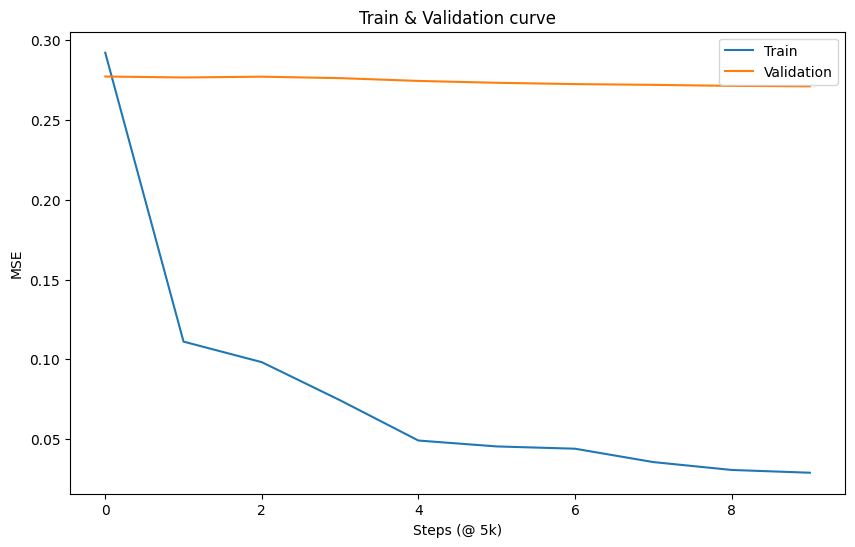

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(all_losses_list, label='Train')
plt.plot(all_v_losses_list, label='Validation')
plt.title('Train & Validation curve')
plt.xlabel('Steps (@ 5k)')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [103]:
model_output_list = []
target_rating_list = []

model.eval()
with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        _, _, model_output = model(test_data['users'],
                             test_data['movies'])
        
        model_output_list.append(model_output.sum().item() / len(test_data['users']))
        target_rating = test_data['ratings']
        target_rating_list.append(target_rating.sum().item() / len(test_data['users']))

        #print(f'model_output:\t{model_output.view(4,)}\ntarget_rating:\t{target_rating}\n')

rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f'rms: {rms}')

rms: 0.5162520072015796


In [ ]:
user_est_true = defaultdict(list)

with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        users = test_data['users']
        movies = test_data['movies']
        ratings = test_data['ratings']

        model_output = model(test_data['users'],
                             test_data['movies'])

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item()
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()

            #print(f'{user_id}, {movie_id}, {pred_rating}, {true_rating}')
            user_est_true[user_id].append((pred_rating, true_rating))

In [ ]:
user_est_true

defaultdict(list,
            {104: [(3.1539053916931152, 3.0),
              (3.2424802780151367, 3.0),
              (3.482470989227295, 4.0),
              (3.2838222980499268, 4.0),
              (3.5465641021728516, 4.0),
              (3.472233772277832, 3.0),
              (3.0259315967559814, 3.5),
              (3.2836291790008545, 4.0),
              (3.2139642238616943, 3.0),
              (3.2919554710388184, 2.5),
              (3.1292428970336914, 2.5),
              (3.164538860321045, 3.0),
              (3.28045654296875, 4.0),
              (3.4248719215393066, 1.5),
              (3.273630380630493, 4.0),
              (2.9363343715667725, 2.5),
              (3.539807081222534, 3.5),
              (3.1204771995544434, 3.0),
              (2.987950563430786, 2.5),
              (3.6319355964660645, 3.5),
              (3.2316932678222656, 3.5),
              (2.8864614963531494, 4.0),
              (3.044698715209961, 3.0),
              (3.06644868850708, 3.0),
    

In [ ]:
with torch.no_grad():
    precisions = dict()
    recalls = dict()

    k = 20
    threshold = 3.5

    for uid, user_ratings in user_est_true.items():
        #print(f'uid: {uid}')
        
        # sort by predicted ratings
        user_ratings.sort(key=lambda x: x[0], reverse=True) 
        #print(len(user_ratings), user_ratings)
        # 
        n_rel = sum([(true_rating >= threshold) for (_, true_rating) in user_ratings])
        n_rec_k = sum([(true_rating >= threshold) for (_, true_rating) in user_ratings[:k]])
        #print(f'n_rel: {n_rel}, n_rec_k: {n_rec_k}')

        n_rel_and_rec_k = sum([((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k]])
        #print(n_rel_and_rec_k)
        
        #print(f'uid: {uid}, n_rel: {n_rel}, n_rec_k: {n_rec_k}, n_rel_and_rec_k: {n_rel_and_rec_k}')
        
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        #break

In [ ]:
print(f'precisions @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}')
print(f'recall @ {k}: {sum(rec for rec in recalls.values()) / len(recalls)}')

precisions @ 20: 0.6774952967850664
recall @ 20: 0.6210187899143237
